In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Load the dataset
df = pd.read_csv('refined_test.csv')

In [2]:
df.head()

,ChangeID,Summary,Priority,StatusReason,Impact,ChangePlanning,Submitter,Coordinator,SubmitDateTime,SchStartDateTime,...,ActualEndDateTime_Times_Only,ActualStartDateTime_Times_Only,SchEndDateTime_Times_Only,Scheduled_Work_Duration,Closeout_Delay,Approval_Delay,Start_Delay,Work_Duration,Is_Completed,Location
0,CRQ000000278909,"AL, Birmingham, APC HQ and Leeds Nokia/Turf Cl...",Low,Successful,Minor,Planned,GPB,TT,2025-03-29 10:42:05,2025-03-29 18:00:00,...,20:00:00,18:02:00,00:00:00,6.0,13.619167,0.122222,7.209722,1.966667,True,AL
1,CRQ000000278912,"GA, Atlanta, Distribution ROW, Repair damaged ...",Medium,Successful,Moderate,Planned,JLM,TT,2025-03-29 13:06:22,2025-03-29 08:00:00,...,14:06:00,08:00:00,18:00:00,10.0,19.690000,3.603333,15.290556,6.100000,True,GA
2,CRQ000000278914,"GA, YPSILANTI LTE G8144, REPLACE LMR-400 COAXI...",Low,Successful,Minor,Planned,WKA,TT,2025-03-29 13:28:53,2025-03-29 07:00:00,...,17:00:00,07:00:00,17:00:00,10.0,18.987778,1.347222,16.171389,10.000000,True,GA
3,CRQ000000278918,"AL, Bessemer, Reconfigure fiber between Bessem...",Medium,Successful,Moderate,Planned,RRR,TT,2025-03-29 14:52:03,2025-03-29 19:00:00,...,23:57:00,19:07:00,00:00:00,5.0,9.581667,0.125278,4.123889,4.833333,True,AL
4,CRQ000000279007,"AL, BIRMINGHAM, APC CORP HQ, TURF CLUB DS CABI...",Low,Successful,Minor,Planned,ZPE,TT,2025-03-29 11:17:04,2025-03-29 18:00:00,...,00:00:00,18:00:00,00:00:00,6.0,9.661389,23.533056,7.182500,6.000000,True,AL


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305 entries, 0 to 1304
Data columns (total 52 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ChangeID                        1305 non-null   object 
 1   Summary                         1305 non-null   object 
 2   Priority                        1305 non-null   object 
 3   StatusReason                    1305 non-null   object 
 4   Impact                          1305 non-null   object 
 5   ChangePlanning                  1305 non-null   object 
 6   Submitter                       1305 non-null   object 
 7   Coordinator                     1305 non-null   object 
 8   SubmitDateTime                  1305 non-null   object 
 9   SchStartDateTime                1305 non-null   object 
 10  SchEndDateTime                  1305 non-null   object 
 11  ActualStartDateTime             1305 non-null   object 
 12  ActualEndDateTime               13

In [4]:
df.dropna(subset=["ChangeID"], inplace=True)  # Drop rows with missing ChangeID
df.fillna({"Priority": "Unknown", "StatusReason": "Pending"}, inplace=True)  # Fill missing values
 
# Drop rows with any remaining missing values
df.dropna(inplace=True)
 
# Step 2: Convert Date Columns to Datetime
date_cols = [
    "SubmitDateTime", "SchStartDateTime", "ApprovalDateTime", 
    "SchForAppDateTime", "ImpInProgDateTime", "LastModifiedDate", "ClosedDateTime", "CompletedDateTime", "ActualEndDateTime", "ActualStartDateTime", "SchEndDateTime"
]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")
 
# Step 3: Standardize Categorical Values
df["Priority"] = df["Priority"].str.capitalize()  # Make consistent (e.g., "Low" instead of "low")
df["StatusReason"] = df["StatusReason"].str.strip().str.title()  # Format correctly
 
# Step 4: Remove Duplicates
# df.drop_duplicates(subset=["ChangeID"], keep="first", inplace=True)
 
# Step 5: Create New Features (e.g., Processing Time)
df["ProcessingTime_Hours"] = (df["ActualEndDateTime"] - df["ActualStartDateTime"]).dt.total_seconds() / 3600
 
# Adjust for cases where ActualEndDateTime is earlier on the same day than ActualStartDateTime
mask = df['ProcessingTime_Hours'] < 0
df.loc[mask, 'ProcessingTime_Hours'] += 24
 
# Extract only the time part from the datetime columns
for col in date_cols:
    df[col + '_Times_Only'] = df[col].dt.time

In [5]:
# Ensure relevant columns are converted to datetime before performing calculations
# datetime_columns = ["SchEndDateTime", "SchStartDateTime", "ClosedDateTime", "CompletedDateTime"]
# for col in datetime_columns:
#     df[col] = pd.to_datetime(df[col], errors="coerce")

# Calculate Scheduled_Work_Duration based on SchEndDateTime and SchStartDateTime
df["Scheduled_Work_Duration"] = (
    (df["SchEndDateTime"] - df["SchStartDateTime"]).dt.total_seconds()
) / 3600  # Convert to hours

# Adjust for cases where SchEndDateTime is earlier on the same day than SchStartDateTime
mask = df['Scheduled_Work_Duration'] < 0
df.loc[mask, 'Scheduled_Work_Duration'] += 24

df["Closeout_Delay"] = (
    (df["ClosedDateTime"] - df["CompletedDateTime"]).dt.total_seconds()
) / 3600  # Convert to hours

# Adjust for cases where ClosedDateTime is earlier on the same day than CompletedDateTime
mask = df['Closeout_Delay'] < 0
df.loc[mask, 'Closeout_Delay'] += 24

# Aggregate refined summary statistics
refined_metrics_summary = {
    "Average Actual Work Duration (hours)": df["ProcessingTime_Hours"].mean(),
    "Median Actual Work Duration (hours)": df["ProcessingTime_Hours"].median(),
    "Average Scheduled Work Duration (hours)": df["Scheduled_Work_Duration"].mean(),
    "Median Scheduled Work Duration (hours)": df["Scheduled_Work_Duration"].median(),
    "Average Closeout Delay (hours)": df["Closeout_Delay"].mean(),
    "Median Closeout Delay (hours)": df["Closeout_Delay"].median(),
}

In [6]:
refined_metrics_summary

{'Average Actual Work Duration (hours)': 5.774621328224776,
 'Median Actual Work Duration (hours)': 5.0,
 'Average Scheduled Work Duration (hours)': 7.184840357598978,
 'Median Scheduled Work Duration (hours)': 7.0,
 'Average Closeout Delay (hours)': 0.22926309067688383,
 'Median Closeout Delay (hours)': 0.0044444444444444444}

In [7]:
# Priority analysis

priority_analysis = df.groupby("Priority").agg({
    "ProcessingTime_Hours": ["mean", "median"],
    "Scheduled_Work_Duration": ["mean", "median"],
    "Closeout_Delay": ["mean", "median"]
}).reset_index()

priority_analysis.columns = ['Priority', 'Avg_Actual_Work_Duration', 'Median_Actual_Work_Duration',
                            'Avg_Scheduled_Work_Duration', 'Median_Scheduled_Work_Duration',
                            'Avg_Closeout_Delay', 'Median_Closeout_Delay']

priority_analysis

# Visualize the priority analysis
# plt.figure(figsize=(12, 6))
# sns.barplot(data=priority_analysis, x='Priority', y='Avg_Actual_Work_Duration')
# plt.title('Average Actual Work Duration by Priority')
# plt.xlabel('Priority')
# plt.ylabel('Average Actual Work Duration (hours)')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

,Priority,Avg_Actual_Work_Duration,Median_Actual_Work_Duration,Avg_Scheduled_Work_Duration,Median_Scheduled_Work_Duration,Avg_Closeout_Delay,Median_Closeout_Delay
0,Low,5.859046,5.0,7.105449,6.983333,0.071149,0.003333
1,Medium,5.560472,5.0,7.386224,7.000000,0.630333,0.017222


In [8]:
def correctWhenEndEarlierThanStart(df, final_col):
    """
    Corrects the end time if it is earlier than the start time on the same day.
    """
    mask = df[final_col] < 0
    df.loc[mask, final_col] += 24

In [9]:
# Ensure relevant columns are converted to datetime
# Identifying Bottlenecks & Delays

# Calculate delays and durations for each task
df["Approval_Delay"] = (df["ApprovalDateTime"] - df["SubmitDateTime"]).dt.total_seconds() / 3600
correctWhenEndEarlierThanStart(df, "Approval_Delay")

df["Start_Delay"] = (df["ActualStartDateTime"] - df["ApprovalDateTime"]).dt.total_seconds() / 3600
correctWhenEndEarlierThanStart(df, "Start_Delay")

df["Work_Duration"] = (df["ActualEndDateTime"] - df["ActualStartDateTime"]).dt.total_seconds() / 3600
correctWhenEndEarlierThanStart(df, "Work_Duration")

df["Closeout_Delay"] = (df["ClosedDateTime"] - df["ActualEndDateTime"]).dt.total_seconds() / 3600
correctWhenEndEarlierThanStart(df, "Closeout_Delay")

# Identify tasks with the highest delays
top_delays = df.nlargest(10, "Closeout_Delay")[["ChangeID", "Priority", "Coordinator", "Closeout_Delay"]]

# Identify coordinators with the highest average delays
coordinator_delays = df.groupby("Coordinator").agg({
    "Approval_Delay": "mean",
    "Start_Delay": "mean",
    "Work_Duration": "mean",
    "Closeout_Delay": "mean"
}).reset_index().sort_values(by="Closeout_Delay", ascending=False)

top_delays

,ChangeID,Priority,Coordinator,Closeout_Delay
286,CRQ000000318807,Low,TT,23.913333
390,CRQ000000336202,Low,TT,23.870278
979,CRQ000000393715,Low,TT,23.833611
731,CRQ000000373808,Low,TT,23.779722
854,CRQ000000387025,Low,TT,23.773333
639,CRQ000000362126,Low,TT,23.582500
703,CRQ000000369630,Low,TT,23.571111
30,CRQ000000282222,Low,TT,23.526667
408,CRQ000000338312,Low,TT,23.518333
1293,CRQ000000403385,Low,TT,23.506389


In [10]:
coordinator_delays

,Coordinator,Approval_Delay,Start_Delay,Work_Duration,Closeout_Delay
1,TT,12.953611,14.083137,5.799591,12.046466
0,HH,7.855426,13.447872,5.376407,8.365184


In [11]:
# Count tasks handled by each Submitter & Coordinator
submitter_workload = df["Submitter"].value_counts().reset_index()
submitter_workload.columns = ["Submitter", "Total_Tasks"]
# show which customer department each submitter belongs to using the CustomerDept
# column
submitter_workload["CustomerDept"] = df.groupby("Submitter")["CustomerDept"].first().values
# calculate each submitter's average processing time
submitter_performance = df.groupby("Submitter").agg({
    "ProcessingTime_Hours": "mean",
    "Closeout_Delay": "mean"
}).reset_index().sort_values(by="ProcessingTime_Hours", ascending=False)
submitter_workload = submitter_workload.merge(submitter_performance, on="Submitter", how="left")

coordinator_workload = df["Coordinator"].value_counts().reset_index()
coordinator_workload.columns = ["Coordinator", "Total_Tasks"]

# Average time taken by each Coordinator
coordinator_performance = df.groupby("Coordinator").agg({
    "ProcessingTime_Hours": "mean",
    "Closeout_Delay": "mean"
}).reset_index().sort_values(by="ProcessingTime_Hours", ascending=False)

# Count pending vs. completed work per Coordinator
df["Is_Completed"] = df["ClosedDateTime"].notnull()
coordinator_pending = df.groupby("Coordinator")["Is_Completed"].value_counts().unstack().fillna(0)

# Ensure the DataFrame has columns before renaming
if not coordinator_pending.empty:
    if coordinator_pending.shape[1] == 2:
        coordinator_pending.columns = ["Pending_Tasks", "Completed_Tasks"]
    elif coordinator_pending.shape[1] == 1:
        coordinator_pending.columns = ["Completed_Tasks"]  # Adjust column name if only one column exists

# Merge workload and pending task counts
coordinator_analysis = coordinator_workload.merge(coordinator_performance, on="Coordinator", how="left")
coordinator_analysis = coordinator_analysis.merge(coordinator_pending, on="Coordinator", how="left")

submitter_workload


,Submitter,Total_Tasks,CustomerDept,ProcessingTime_Hours,Closeout_Delay
0,RPY,105,TELECOM CORE SERVICES,4.480294,8.990444
1,RBK,101,TELECOM CORE SERVICES,4.921452,15.621595
2,LPE,97,TELECOM EDGE SERVICES,3.962371,13.987932
3,MPH,83,FO AL OPERATIONS,6.516667,11.037975
4,DRB,80,RAN OPERATIONS,4.994792,12.093535
...,...,...,...,...,...
58,JCT,1,TELECOM AGGREGATE SERVICES,16.000000,9.476111
59,RLJ,1,FO AL OPERATIONS,1.000000,0.034444
60,WJO,1,FO GA OPERATIONS,1.250000,14.278056
61,RFU,1,FO NE OPERATIONS,10.000000,16.691667


In [12]:
coordinator_analysis

,Coordinator,Total_Tasks,ProcessingTime_Hours,Closeout_Delay,Completed_Tasks
0,TT,1228,5.799591,12.046466,1228
1,HH,77,5.376407,8.365184,77


In [13]:
# Case Volume Over Time

# Count case volume by month and quarter
case_volume_monthly = df['CompletedMonth'].value_counts().reset_index()
case_volume_monthly.columns = ['CompletedMonth', 'CaseVolume']
case_volume_monthly['CompletedMonth'] = pd.to_datetime(case_volume_monthly['CompletedMonth'], format='%Y-%m').dt.to_period('M')
case_volume_monthly = case_volume_monthly.sort_values('CompletedMonth')

case_volume_quarterly = df['CompletedYearQtr'].value_counts().reset_index()
case_volume_quarterly.columns = ['CompletedYearQtr', 'CaseVolume']
case_volume_quarterly['CompletedYearQtr'] = case_volume_quarterly['CompletedYearQtr'].str.extract(r'(\d{4}-Q\d)')[0]
case_volume_quarterly['CompletedYearQtr'] = pd.PeriodIndex(case_volume_quarterly['CompletedYearQtr'], freq='Q')
case_volume_quarterly = case_volume_quarterly.sort_values('CompletedYearQtr')

# Count cases by Priority & Category
case_volume_priority = df['Priority'].value_counts().reset_index()
case_volume_priority.columns = ['Priority', 'CaseVolume']
case_volume_category = df['ProdCat3'].value_counts().reset_index()
case_volume_category.columns = ['ProdCat3', 'CaseVolume']

# print("Case Volume by Priority:\n", case_volume_priority)
# print("Case Volume by Category:\n", case_volume_category)
# print("Quarterly Case Volume:\n", case_volume_quarterly)


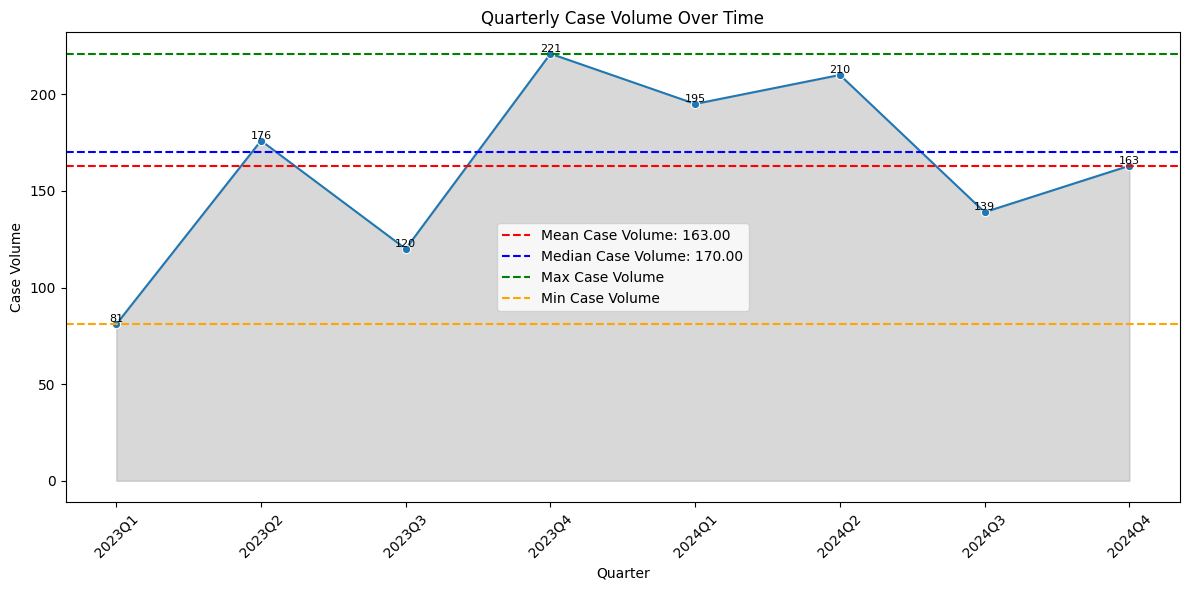

In [14]:
# case_volume_quarterly
# Visualize the case volume over time
# Convert CompletedYearQtr to string for compatibility with sns.lineplot
case_volume_quarterly['CompletedYearQtr'] = case_volume_quarterly['CompletedYearQtr'].astype(str)
mean_case_volume = case_volume_quarterly['CaseVolume'].mean().round()
median_case_volume = case_volume_quarterly['CaseVolume'].median().round()

plt.figure(figsize=(12, 6))
sns.lineplot(data=case_volume_quarterly, x='CompletedYearQtr', y='CaseVolume', marker='o')
plt.axhline(mean_case_volume, color='red', linestyle='--', label=f'Mean Case Volume: {mean_case_volume:.2f}')
plt.axhline(median_case_volume, color='blue', linestyle='--', label=f'Median Case Volume: {median_case_volume:.2f}')
plt.axhline(case_volume_quarterly['CaseVolume'].max(), color='green', linestyle='--', label='Max Case Volume')
plt.axhline(case_volume_quarterly['CaseVolume'].min(), color='orange', linestyle='--', label='Min Case Volume')
plt.fill_between(case_volume_quarterly['CompletedYearQtr'], 0, case_volume_quarterly['CaseVolume'], alpha=0.3, color='gray')

# Add labels for each data point
for i, row in case_volume_quarterly.iterrows():
    plt.text(row['CompletedYearQtr'], row['CaseVolume'], str(row['CaseVolume']), ha='center', va='bottom', fontsize=8)

plt.title('Quarterly Case Volume Over Time')
plt.xlabel('Quarter')
plt.ylabel('Case Volume')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
# case_volume_quarterly.to_csv('case_volume_quarterly.csv', index=False)

This line plot shows the case volume by each yearly quarter from 2023 to 2024. The x-axis represents the quarters, while the y-axis represents the case volume. The data is represented by a line connecting the points for each quarter. Based on the data, the case volume appears to be increasing over time, with a noticeable spike in Q2 of 2024 and peaking in Q4 of 2023. The reason for this increase could be attributed to various factors such as seasonal trends, changes in regulations, or increased demand for services. The data suggests that the case volume is expected to continue to rise in the coming quarters, indicating a growing trend in the industry.

In [16]:
q4_2023_data = df[df['CompletedYearQtr'] == '2023-Q4']

q4_2023_data = q4_2023_data[['ChangeID', 'Priority', 'Submitter', 'Coordinator', 'StatusReason', 'ProcessingTime_Hours', 'Scheduled_Work_Duration', 'Closeout_Delay']]
q4_2023_data.reset_index(drop=True, inplace=True)

q4_2023_data['Number of Successful Changes'] = q4_2023_data[q4_2023_data['StatusReason'] == 'Successful'].groupby('Submitter')['ChangeID'].transform('count')
q4_2023_data['Number of Failed Changes'] = q4_2023_data[q4_2023_data['StatusReason'] == 'Unsuccessful'].groupby('Submitter')['ChangeID'].transform('count')
q4_2023_data['Number of Failed Changes'].fillna(0, inplace=True)
q4_2023_data.dropna(subset=['Number of Successful Changes'], inplace=True)
q4_2023_data.reset_index(drop=True, inplace=True)

q4_2023_data.drop(columns=['StatusReason', 'Coordinator'], inplace=True)

q4_2023_data

C:\Users\prasa\AppData\Local\Temp\ipykernel_13636\2743288469.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  q4_2023_data['Number of Failed Changes'].fillna(0, inplace=True)


,ChangeID,Priority,Submitter,ProcessingTime_Hours,Scheduled_Work_Duration,Closeout_Delay,Number of Successful Changes,Number of Failed Changes
0,CRQ000000326404,Low,DWM,3.566667,14.000000,8.550833,7.0,0.0
1,CRQ000000334422,Low,MVW,8.983333,12.000000,2.414722,3.0,0.0
2,CRQ000000334633,Low,JHW,2.950000,4.000000,2.193889,15.0,0.0
3,CRQ000000334637,Low,JHW,2.983333,4.000000,2.129444,15.0,0.0
4,CRQ000000335001,Low,LPE,3.000000,3.000000,2.886111,61.0,0.0
...,...,...,...,...,...,...,...,...
212,CRQ000000355602,Low,CDL,11.000000,11.000000,14.959722,12.0,0.0
213,CRQ000000355707,Low,LPE,5.000000,5.000000,19.519444,61.0,0.0
214,CRQ000000355716,Low,ADL,5.983333,5.983333,10.334722,9.0,0.0
215,CRQ000000356016,Low,JHW,6.000000,6.000000,3.477778,15.0,0.0


In [17]:
# Visualize 

In [18]:
# Case Volume by Product Category (Technology Area)
case_by_prodcat2 = df["ProdCat2"].value_counts()

# Case Volume by Product Category 3 (Equipment Type)
case_by_prodcat3 = df["ProdCat3"].value_counts()

# Case Volume by Operation Category (Type of Operation)
case_by_opcat1 = df["OpCat1"].value_counts()

# Case Volume by Business Unit (Operating Company)
case_by_customer_opco = df["CustomerOpco"].value_counts()

# Case Volume by Customer Group (Organization under VP)
case_by_customer_dept = df["CustomerDept"].value_counts()

# Prepare results
case_volume_metrics = {
    "Cases by Product Category (ProdCat2)": case_by_prodcat2,
    "Cases by Equipment Type (ProdCat3)": case_by_prodcat3,
    "Cases by Operation Category (OpCat1)": case_by_opcat1,
    "Cases by Operating Company (CustomerOpCo)": case_by_customer_opco,
    "Cases by Customer Dept": case_by_customer_dept
}

print(case_volume_metrics)


{'Cases by Product Category (ProdCat2)': ProdCat2
Transport Device        1003
Facilities Component     302
Name: count, dtype: int64, 'Cases by Equipment Type (ProdCat3)': ProdCat3
Optical Transport Equipment             417
FIBER OPTIC TRANSPORT - FDP / OSP       213
DC Backup System                        212
Other Transport Device                  199
Microwave TX/RX (Licensed)               94
Antenna System                           53
Generator                                32
Uninterruptable Power Supply (UPS)       23
Tower Structure                          14
Surge Suppression                        12
Cables, jumpers, and connectors          11
Microwave TX/RX (Unlicensed)              9
Cable management system                   3
Cabinet / Rack                            3
Transformer                               2
Patch panel/Fiber distribution panel      1
CSU / DSU                                 1
Service Aggregation Router                1
Synchronization Equipment 

In [19]:
#  Determine which product categories are most frequently upgraded or repaired in Q4 2023

# Filter the DataFrame for Q4 2023
q4_2023_data = df[df["CompletedYearQtr"] == "2023-Q4"]
# Filter the DataFrame for specific operation categories
# and count occurrences of each product category
upgraded_counts_op1 = q4_2023_data[q4_2023_data["OpCat1"] == "Upgrade/Modify"]["ProdCat3"].value_counts()
upgraded_counts_op1 = upgraded_counts_op1.reset_index()
upgraded_counts_op1.columns = ["ProdCat3", "Upgrade Count"]
upgraded_counts_op1 = upgraded_counts_op1.sort_values(by="Upgrade Count", ascending=False)
upgraded_counts_op1.reset_index(drop=True, inplace=True)

repaired_counts_op1 = q4_2023_data[q4_2023_data["OpCat1"] == "Repair"]["ProdCat3"].value_counts()
repaired_counts_op1 = repaired_counts_op1.reset_index()
repaired_counts_op1.columns = ["ProdCat3", "Repair Count"]
repaired_counts_op1 = repaired_counts_op1.sort_values(by="Repair Count", ascending=False)
repaired_counts_op1.reset_index(drop=True, inplace=True)

migrated_counts_op1 = q4_2023_data[q4_2023_data["OpCat1"] == "Migrate"]["ProdCat3"].value_counts()
migrated_counts_op1 = migrated_counts_op1.reset_index()
migrated_counts_op1.columns = ["ProdCat3", "Migrate Count"]
migrated_counts_op1 = migrated_counts_op1.sort_values(by="Migrate Count", ascending=False)
migrated_counts_op1.reset_index(drop=True, inplace=True)

installed_counts_op1 = q4_2023_data[q4_2023_data["OpCat1"] == "Install"]["ProdCat3"].value_counts()
installed_counts_op1 = installed_counts_op1.reset_index()
installed_counts_op1.columns = ["ProdCat3", "Install Count"]
installed_counts_op1 = installed_counts_op1.sort_values(by="Install Count", ascending=False)
installed_counts_op1.reset_index(drop=True, inplace=True)

remove_counts_op1 = q4_2023_data[q4_2023_data["OpCat1"] == "Remove/Retire"]["ProdCat3"].value_counts()
remove_counts_op1 = remove_counts_op1.reset_index()
remove_counts_op1.columns = ["ProdCat3", "Remove Count"]
remove_counts_op1 = remove_counts_op1.sort_values(by="Remove Count", ascending=False)
remove_counts_op1.reset_index(drop=True, inplace=True)
# Merge the counts into a single DataFrame
merged_counts_op1 = pd.merge(upgraded_counts_op1, repaired_counts_op1, on="ProdCat3", how="outer")
merged_counts_op1 = pd.merge(merged_counts_op1, migrated_counts_op1, on="ProdCat3", how="outer")
merged_counts_op1 = pd.merge(merged_counts_op1, installed_counts_op1, on="ProdCat3", how="outer")
merged_counts_op1 = pd.merge(merged_counts_op1, remove_counts_op1, on="ProdCat3", how="outer")
merged_counts_op1.fillna(0, inplace=True)
merged_counts_op1 = merged_counts_op1.astype({"Upgrade Count": int, "Repair Count": int, "Migrate Count": int, "Install Count": int, "Remove Count": int})
merged_counts_op1.reset_index(drop=True, inplace=True)

# Calculate the total count of occurrences for each ProdCat3
cqr_counts = q4_2023_data["ProdCat3"].value_counts().reset_index()
cqr_counts.columns = ["ProdCat3", "CQR Count"]

# Merge the CQR counts into the merged_counts_op1 DataFrame
merged_counts_op1 = pd.merge(merged_counts_op1, cqr_counts, on="ProdCat3", how="left")

# Sort by the CQR Count column
merged_counts_op1 = merged_counts_op1.sort_values(by="CQR Count", ascending=False)
merged_counts_op1.reset_index(drop=True, inplace=True)
merged_counts_op1.columns = ["ProdCat3", "Upgrade Count", "Repair Count", "Migrate Count", "Install Count", "Remove Count", "CQR Count"]

# Display the final DataFrame
final_res = merged_counts_op1.head(10)

final_res.reset_index(drop=True, inplace=True)
final_res.columns = ["Product Category", "Upgrade Count", "Repair Count", "Migrate Count", "Install Count", "Remove Count", "CQR Count"]

final_res

,Product Category,Upgrade Count,Repair Count,Migrate Count,Install Count,Remove Count,CQR Count
0,DC Backup System,60,1,0,0,7,68
1,Optical Transport Equipment,49,2,0,4,0,55
2,FIBER OPTIC TRANSPORT - FDP / OSP,15,3,2,14,0,34
3,Other Transport Device,13,2,15,0,1,31
4,Microwave TX/RX (Licensed),5,1,0,2,0,8
5,Surge Suppression,0,8,0,0,0,8
6,Antenna System,2,0,1,4,0,7
7,Microwave TX/RX (Unlicensed),5,0,0,0,0,5
8,Generator,2,0,0,0,0,2
9,Power Strip,0,1,0,0,0,1


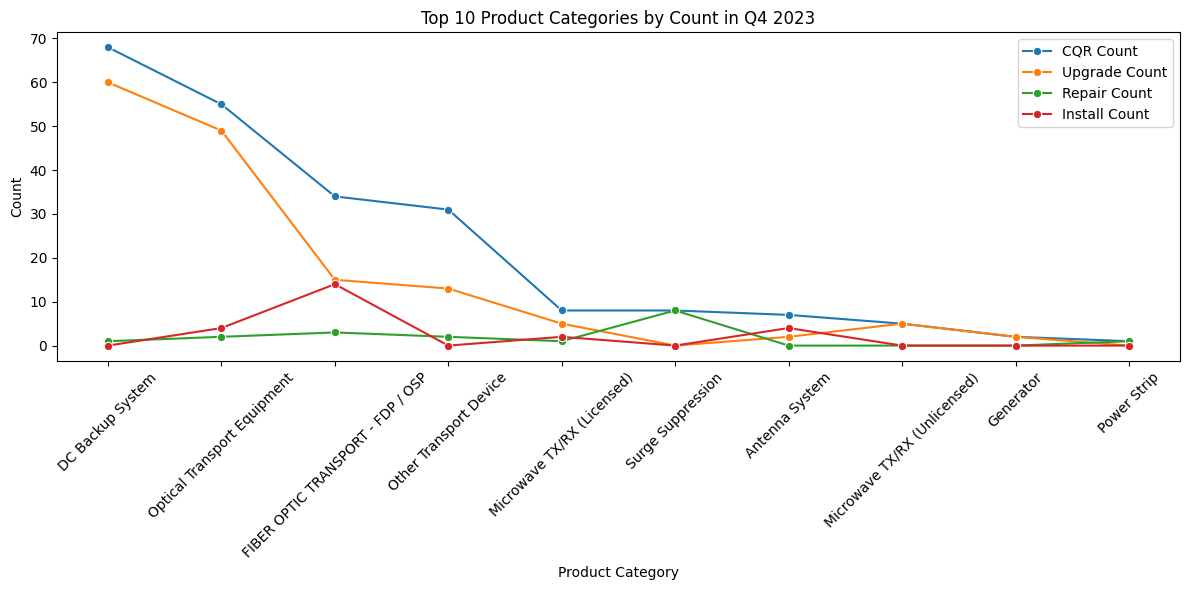

In [20]:
# Plot the top 10 product categories by with lines of CQR Count, Upgrade Count, Repair Count, Migrate Count, Install Count, Remove Count
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_res, x="Product Category", y="CQR Count", label="CQR Count", marker='o')
sns.lineplot(data=final_res, x="Product Category", y="Upgrade Count", label="Upgrade Count", marker='o')
sns.lineplot(data=final_res, x="Product Category", y="Repair Count", label="Repair Count", marker='o')
sns.lineplot(data=final_res, x="Product Category", y="Install Count", label="Install Count", marker='o')
plt.title('Top 10 Product Categories by Count in Q4 2023')
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# final_res.to_csv('top_10_product_categories_by_operation_counts_in_Q4_2023.csv', index=False)

In [22]:
#  Determine which product categories are most frequently upgraded or repaired in Q4 2023

# Filter the DataFrame for Q4 2023
q1_2023_data = df[df["CompletedYearQtr"] == "2023-Q1"]
# Filter the DataFrame for specific operation categories
# and count occurrences of each product category
upgraded_counts_op1 = q1_2023_data[q1_2023_data["OpCat1"] == "Upgrade/Modify"]["ProdCat3"].value_counts()
upgraded_counts_op1 = upgraded_counts_op1.reset_index()
upgraded_counts_op1.columns = ["ProdCat3", "Upgrade Count"]
upgraded_counts_op1 = upgraded_counts_op1.sort_values(by="Upgrade Count", ascending=False)
upgraded_counts_op1.reset_index(drop=True, inplace=True)

repaired_counts_op1 = q1_2023_data[q1_2023_data["OpCat1"] == "Repair"]["ProdCat3"].value_counts()
repaired_counts_op1 = repaired_counts_op1.reset_index()
repaired_counts_op1.columns = ["ProdCat3", "Repair Count"]
repaired_counts_op1 = repaired_counts_op1.sort_values(by="Repair Count", ascending=False)
repaired_counts_op1.reset_index(drop=True, inplace=True)

migrated_counts_op1 = q1_2023_data[q1_2023_data["OpCat1"] == "Migrate"]["ProdCat3"].value_counts()
migrated_counts_op1 = migrated_counts_op1.reset_index()
migrated_counts_op1.columns = ["ProdCat3", "Migrate Count"]
migrated_counts_op1 = migrated_counts_op1.sort_values(by="Migrate Count", ascending=False)
migrated_counts_op1.reset_index(drop=True, inplace=True)

installed_counts_op1 = q1_2023_data[q1_2023_data["OpCat1"] == "Install"]["ProdCat3"].value_counts()
installed_counts_op1 = installed_counts_op1.reset_index()
installed_counts_op1.columns = ["ProdCat3", "Install Count"]
installed_counts_op1 = installed_counts_op1.sort_values(by="Install Count", ascending=False)
installed_counts_op1.reset_index(drop=True, inplace=True)

remove_counts_op1 = q1_2023_data[q1_2023_data["OpCat1"] == "Remove/Retire"]["ProdCat3"].value_counts()
remove_counts_op1 = remove_counts_op1.reset_index()
remove_counts_op1.columns = ["ProdCat3", "Remove Count"]
remove_counts_op1 = remove_counts_op1.sort_values(by="Remove Count", ascending=False)
remove_counts_op1.reset_index(drop=True, inplace=True)
# Merge the counts into a single DataFrame
merged_counts_op1 = pd.merge(upgraded_counts_op1, repaired_counts_op1, on="ProdCat3", how="outer")
merged_counts_op1 = pd.merge(merged_counts_op1, migrated_counts_op1, on="ProdCat3", how="outer")
merged_counts_op1 = pd.merge(merged_counts_op1, installed_counts_op1, on="ProdCat3", how="outer")
merged_counts_op1 = pd.merge(merged_counts_op1, remove_counts_op1, on="ProdCat3", how="outer")
merged_counts_op1.fillna(0, inplace=True)
merged_counts_op1 = merged_counts_op1.astype({"Upgrade Count": int, "Repair Count": int, "Migrate Count": int, "Install Count": int, "Remove Count": int})
merged_counts_op1.reset_index(drop=True, inplace=True)

# Calculate the total count of occurrences for each ProdCat3
cqr_counts = q1_2023_data["ProdCat3"].value_counts().reset_index()
cqr_counts.columns = ["ProdCat3", "CQR Count"]

# Merge the CQR counts into the merged_counts_op1 DataFrame
merged_counts_op1 = pd.merge(merged_counts_op1, cqr_counts, on="ProdCat3", how="left")

# Sort by the CQR Count column
merged_counts_op1 = merged_counts_op1.sort_values(by="CQR Count", ascending=False)
merged_counts_op1.reset_index(drop=True, inplace=True)
merged_counts_op1.columns = ["ProdCat3", "Upgrade Count", "Repair Count", "Migrate Count", "Install Count", "Remove Count", "CQR Count"]

# Display the final DataFrame
final_res = merged_counts_op1.head(10)

final_res.reset_index(drop=True, inplace=True)
final_res.columns = ["Product Category", "Upgrade Count", "Repair Count", "Migrate Count", "Install Count", "Remove Count", "CQR Count"]

final_res

,Product Category,Upgrade Count,Repair Count,Migrate Count,Install Count,Remove Count,CQR Count
0,Optical Transport Equipment,20,4,2,1,2,29
1,Other Transport Device,7,7,5,0,0,19
2,FIBER OPTIC TRANSPORT - FDP / OSP,3,1,0,7,0,11
3,Microwave TX/RX (Licensed),2,5,0,0,0,7
4,DC Backup System,2,1,0,1,0,4
5,Antenna System,0,1,0,2,0,3
6,"Cables, jumpers, and connectors",1,1,0,1,0,3
7,Generator,1,1,0,0,0,2
8,CSU / DSU,0,0,1,0,0,1
9,Tower Structure,0,1,0,0,0,1


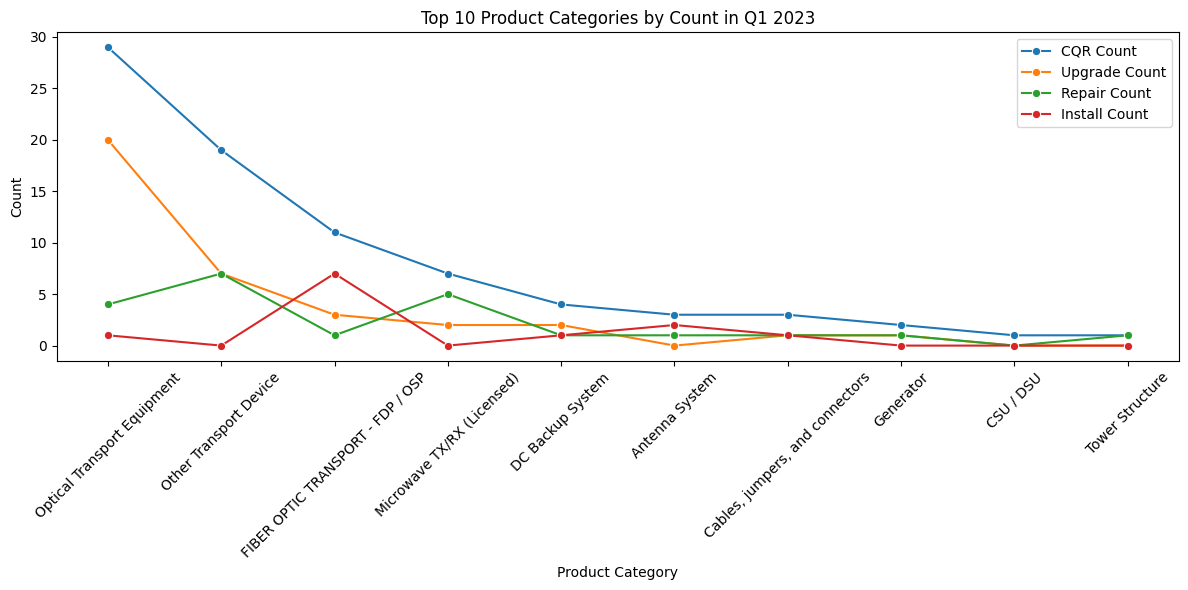

In [23]:
# Plot the top 10 product categories by with lines of CQR Count, Upgrade Count, Repair Count, Migrate Count, Install Count, Remove Count
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_res, x="Product Category", y="CQR Count", label="CQR Count", marker='o')
sns.lineplot(data=final_res, x="Product Category", y="Upgrade Count", label="Upgrade Count", marker='o')
sns.lineplot(data=final_res, x="Product Category", y="Repair Count", label="Repair Count", marker='o')
sns.lineplot(data=final_res, x="Product Category", y="Install Count", label="Install Count", marker='o')
plt.title('Top 10 Product Categories by Count in Q1 2023')
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
# final_res.to_csv('top_10_product_categories_by_operation_counts_in_Q1_2023.csv', index=False)


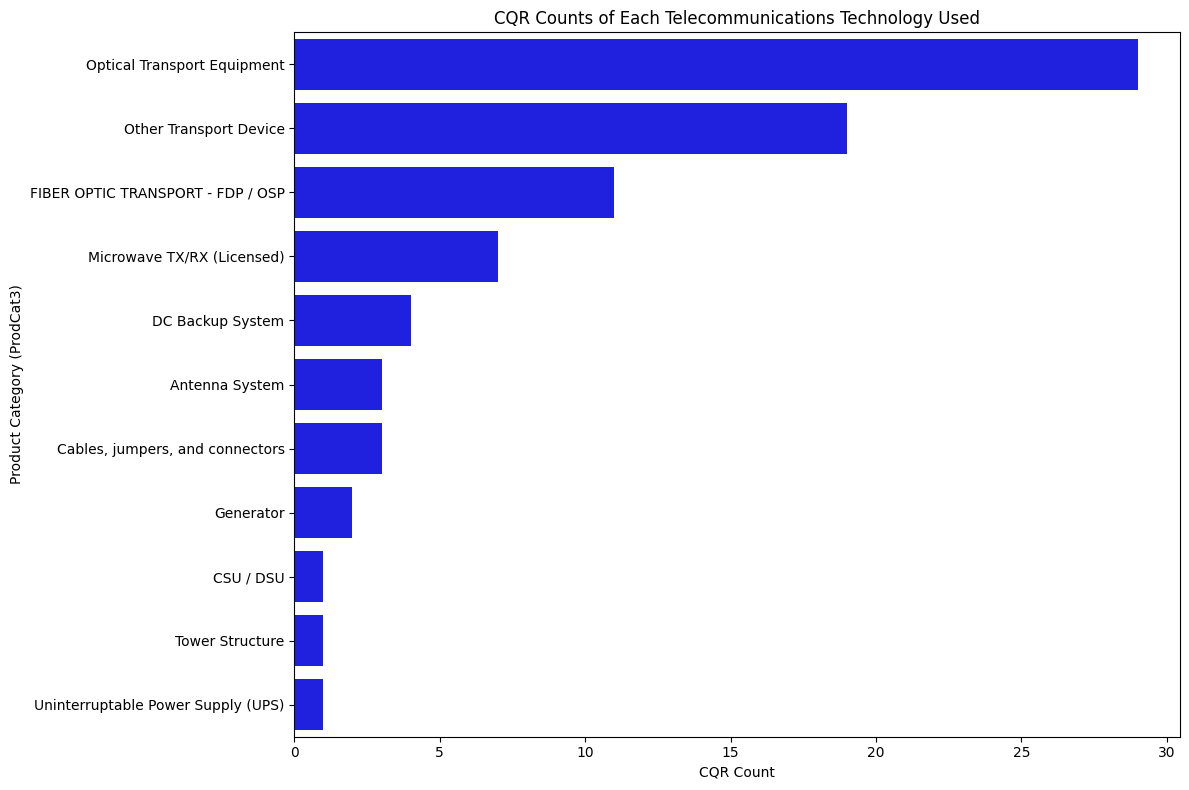

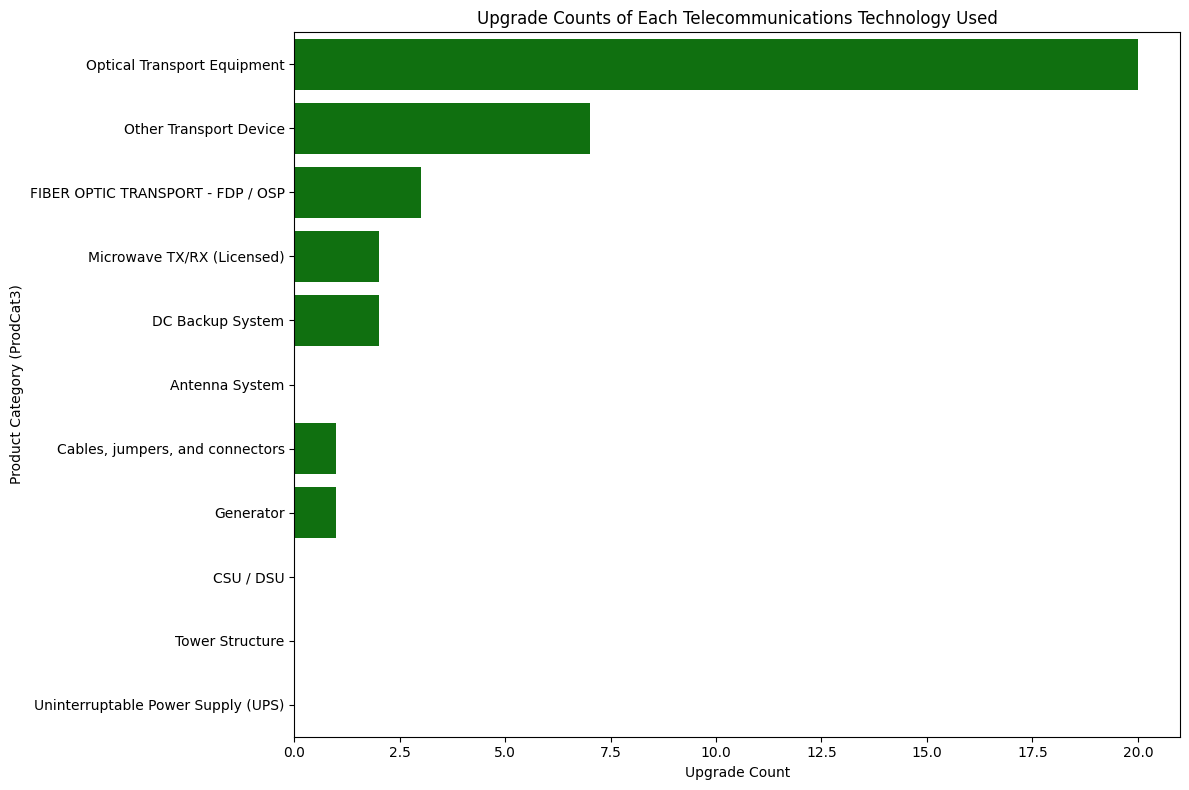

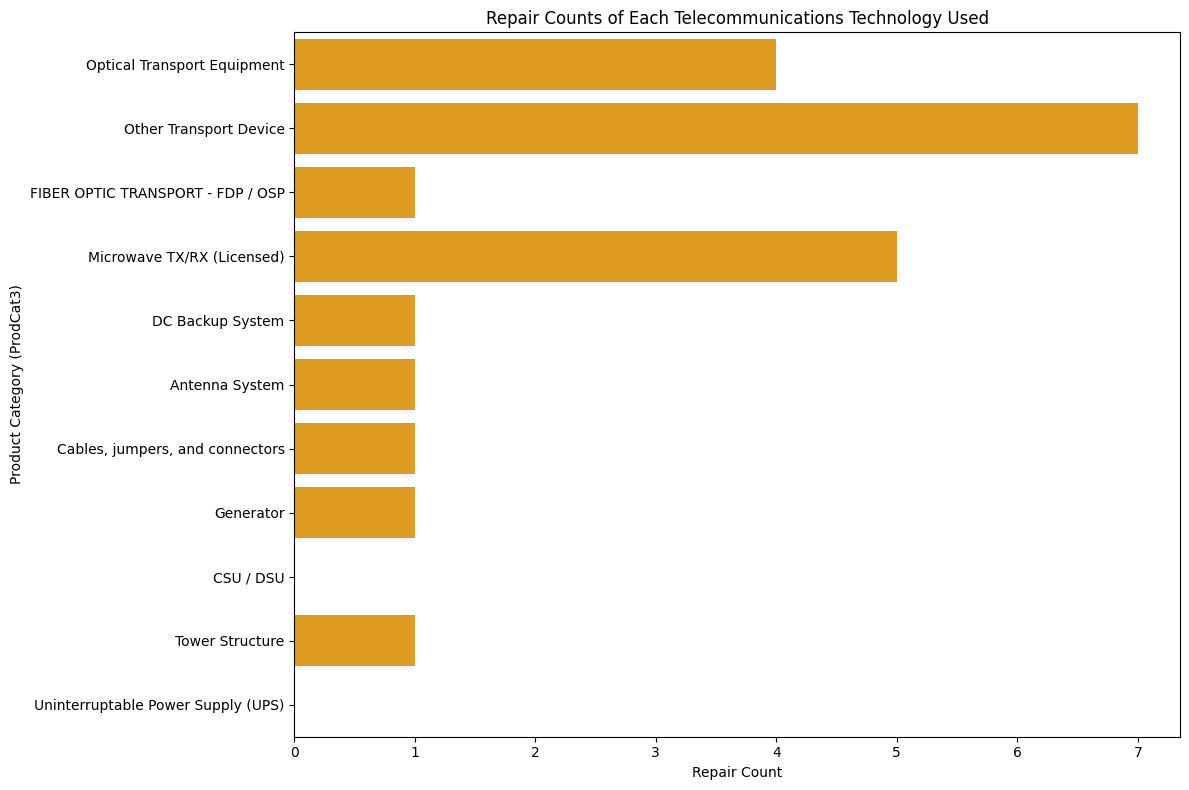

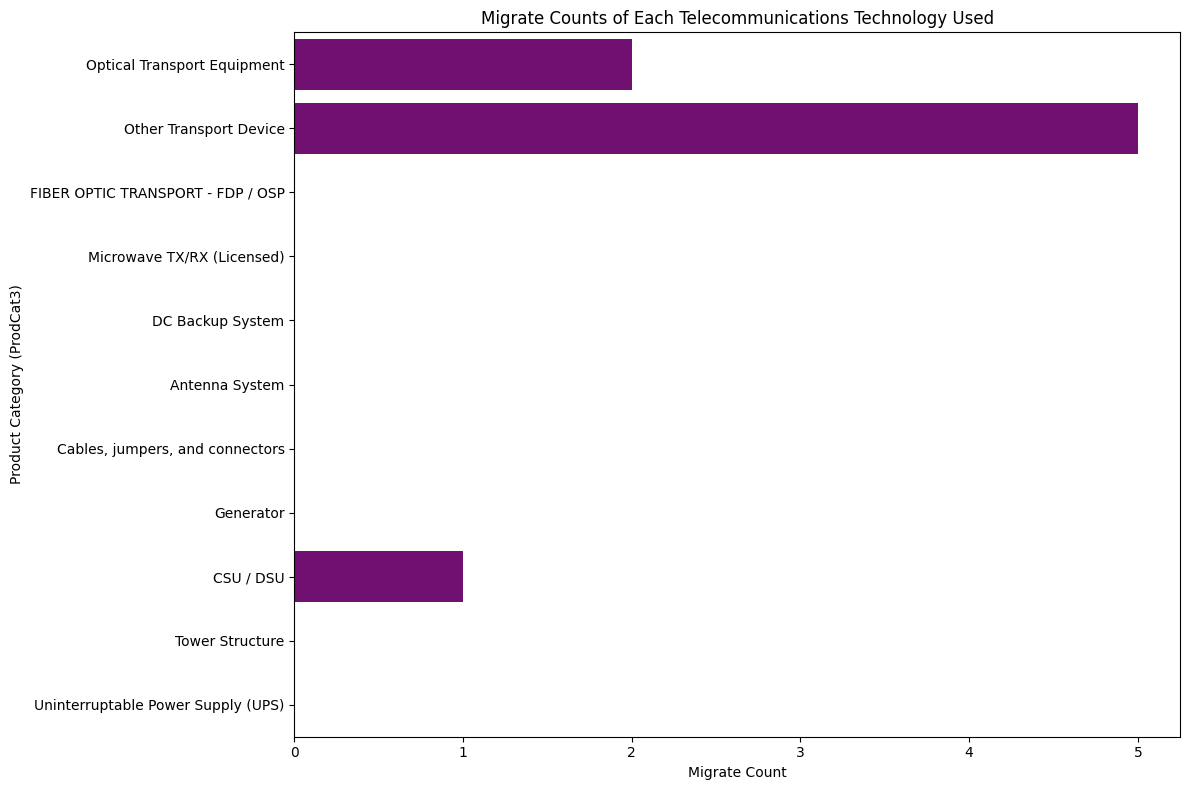

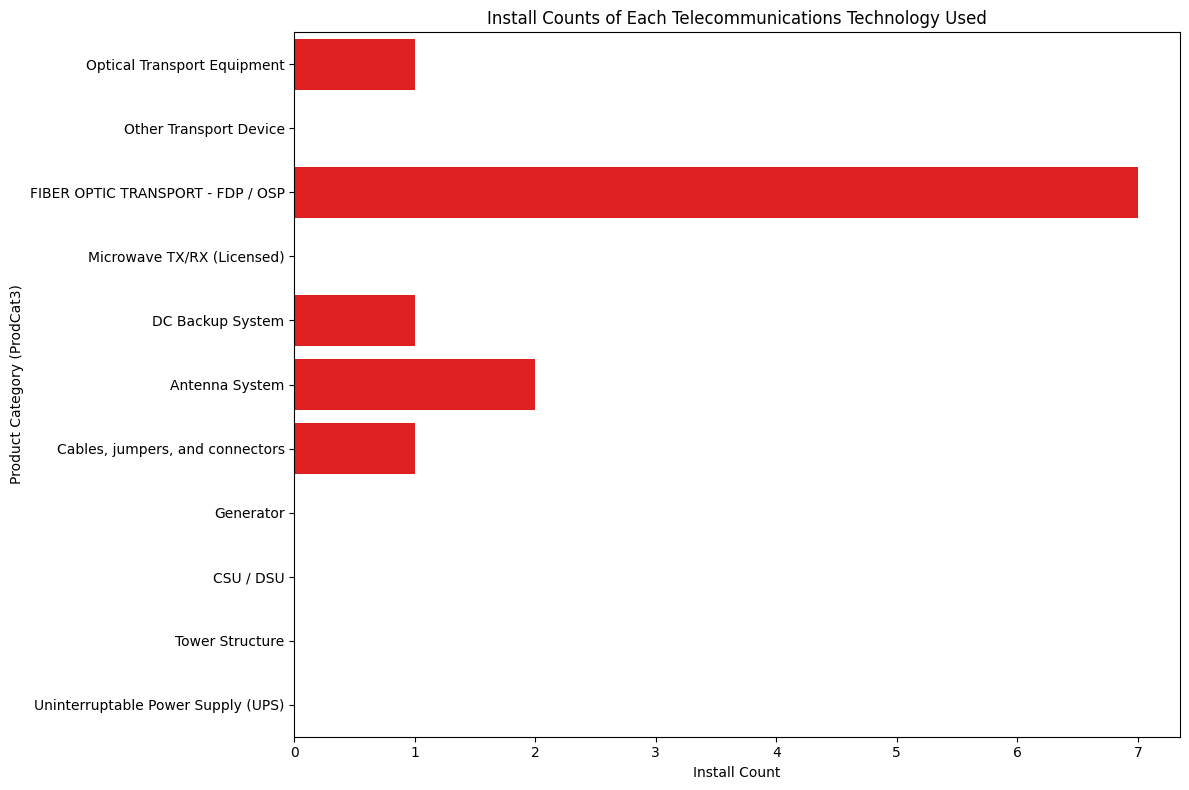

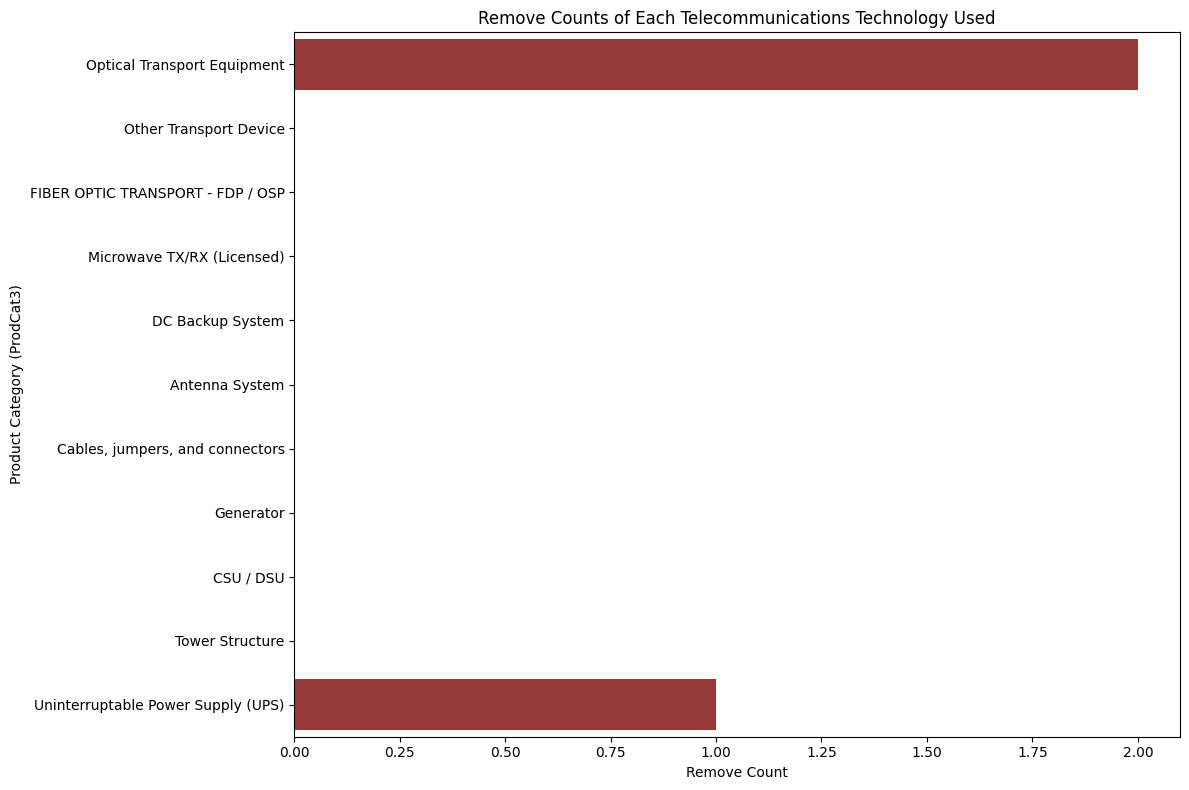

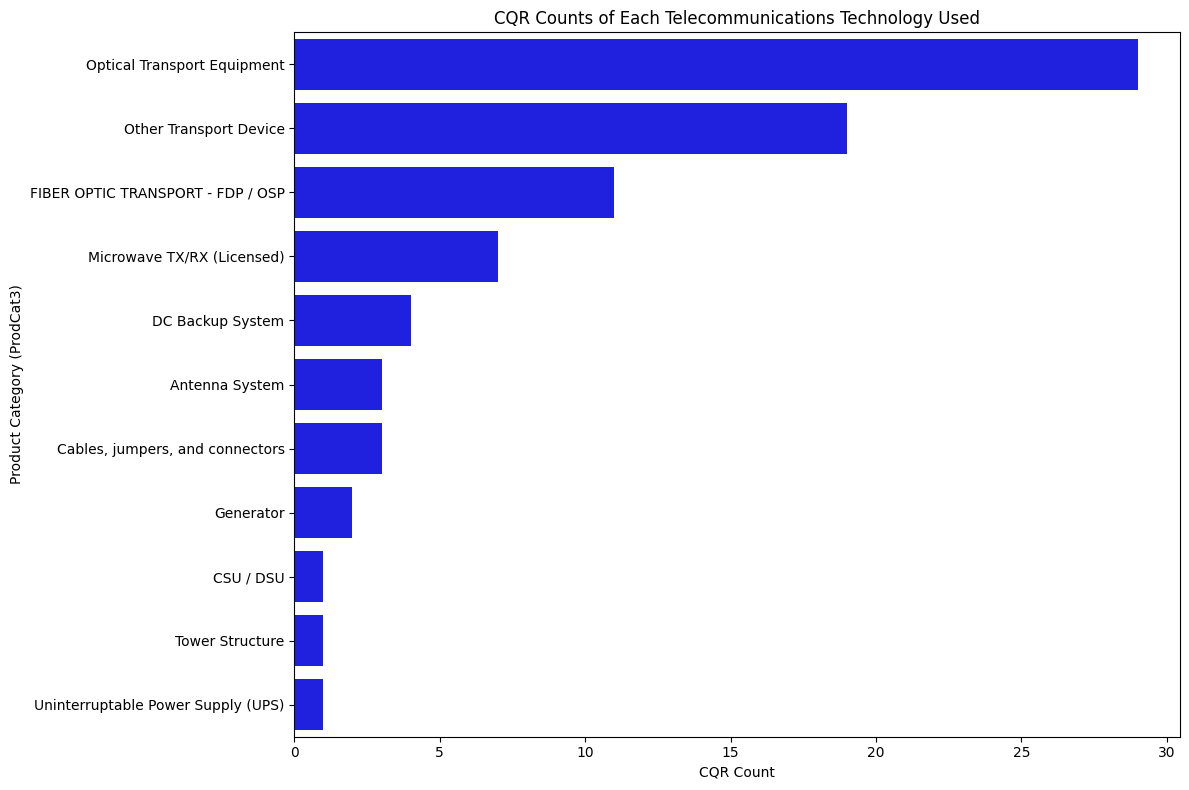

In [26]:
# Visualize the cqr counts of each operation category using horizontal bar plots
plt.figure(figsize=(12, 8))
sns.barplot(data=merged_counts_op1, x='CQR Count', y='ProdCat3', color='blue')
plt.title('CQR Counts of Each Telecommunications Technology Used')
plt.xlabel('CQR Count')
plt.ylabel('Product Category (ProdCat3)')
plt.tight_layout()
plt.show()

# Visualize the counts of each operation category using horizontal bar plots
plt.figure(figsize=(12, 8))
sns.barplot(data=merged_counts_op1, x='Upgrade Count', y='ProdCat3', color='green')
plt.title('Upgrade Counts of Each Telecommunications Technology Used')
plt.xlabel('Upgrade Count')
plt.ylabel('Product Category (ProdCat3)')
plt.tight_layout()
plt.show()

# Visualize the counts of each operation category using horizontal bar plots
plt.figure(figsize=(12, 8))
sns.barplot(data=merged_counts_op1, x='Repair Count', y='ProdCat3', color='orange')
plt.title('Repair Counts of Each Telecommunications Technology Used')
plt.xlabel('Repair Count')
plt.ylabel('Product Category (ProdCat3)')
plt.tight_layout()
plt.show()

# Visualize the counts of each operation category using horizontal bar plots
plt.figure(figsize=(12, 8))
sns.barplot(data=merged_counts_op1, x='Migrate Count', y='ProdCat3', color='purple')
plt.title('Migrate Counts of Each Telecommunications Technology Used')
plt.xlabel('Migrate Count')
plt.ylabel('Product Category (ProdCat3)')
plt.tight_layout()
plt.show()

# Visualize the counts of each operation category using horizontal bar plots
plt.figure(figsize=(12, 8))
sns.barplot(data=merged_counts_op1, x='Install Count', y='ProdCat3', color='red')
plt.title('Install Counts of Each Telecommunications Technology Used')
plt.xlabel('Install Count')
plt.ylabel('Product Category (ProdCat3)')
plt.tight_layout()
plt.show()

# Visualize the counts of each operation category using horizontal bar plots
plt.figure(figsize=(12, 8))
sns.barplot(data=merged_counts_op1, x='Remove Count', y='ProdCat3', color='brown')
plt.title('Remove Counts of Each Telecommunications Technology Used')
plt.xlabel('Remove Count')
plt.ylabel('Product Category (ProdCat3)')
plt.tight_layout()
plt.show()

# Visualize the counts of each operation category using horizontal bar plots
plt.figure(figsize=(12, 8))
sns.barplot(data=merged_counts_op1, x='CQR Count', y='ProdCat3', color='blue')
plt.title('CQR Counts of Each Telecommunications Technology Used')
plt.xlabel('CQR Count')
plt.ylabel('Product Category (ProdCat3)')
plt.tight_layout()
plt.show()


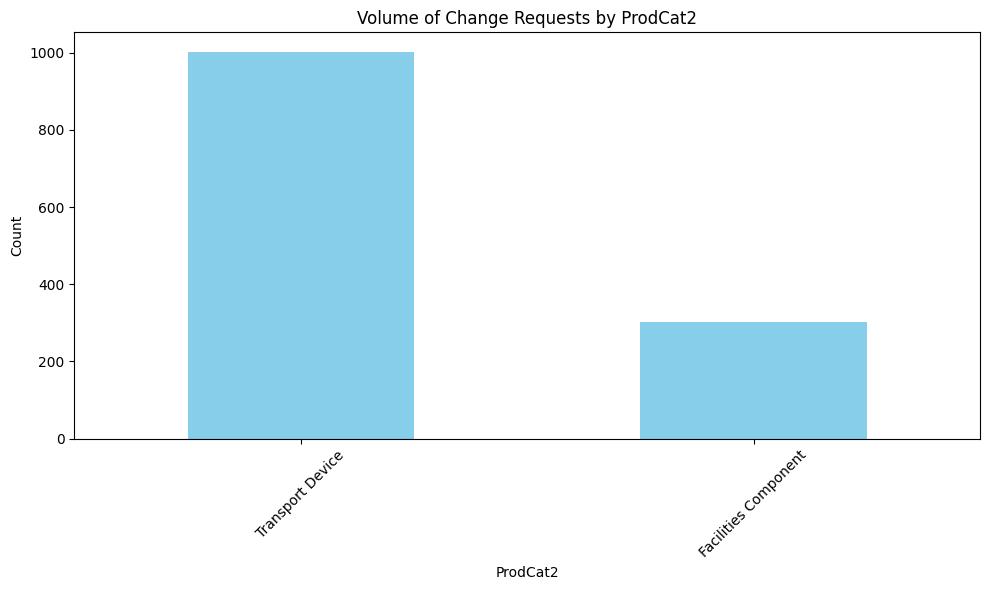

In [27]:
# Analysis: Volume of Change Requests by ProdCat2
prodcat2_counts = df['ProdCat2'].value_counts()

plt.figure(figsize=(10, 6))
prodcat2_counts.plot(kind='bar', color='skyblue')
plt.title("Volume of Change Requests by ProdCat2")
plt.xlabel("ProdCat2")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

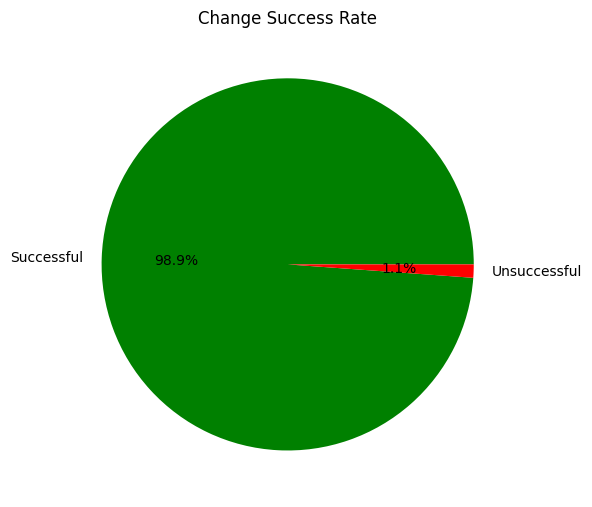

In [28]:
# Analysis: Change Success Rate
change_success_counts = df['ChangeSuccess'].value_counts(normalize=True) * 100

plt.figure(figsize=(6, 6))
change_success_counts.plot(kind='pie', autopct='%1.1f%%', colors=['green', 'red'], labels=['Successful', 'Unsuccessful'])
plt.title("Change Success Rate")
plt.ylabel("")  # Remove y-axis label for pie chart
plt.tight_layout()
plt.show()

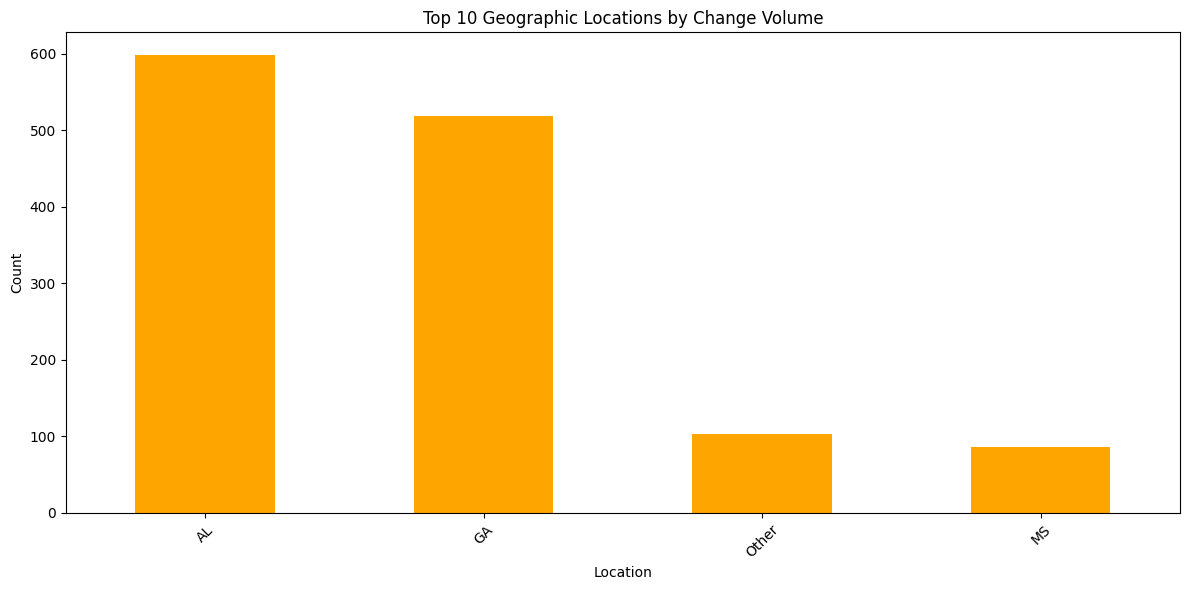

In [29]:
state_set = set(["AL", "GA", "MS"])

# if any location is different from the state set, then mark it as "Other"
df['Location'] = df['Summary'].str.split(',').str[0].str.strip()

df['Location'] = df['Location'].apply(lambda x: x if x in state_set else 'Other')

location_counts = df['Location'].value_counts().head(10)

plt.figure(figsize=(12, 6))
location_counts.plot(kind='bar', color='orange')
plt.title("Top 10 Geographic Locations by Change Volume")
plt.xlabel("Location")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:
df.to_csv('refined_test.csv', index=False)

In [31]:
df

,ChangeID,Summary,Priority,StatusReason,Impact,ChangePlanning,Submitter,Coordinator,SubmitDateTime,SchStartDateTime,...,ActualEndDateTime_Times_Only,ActualStartDateTime_Times_Only,SchEndDateTime_Times_Only,Scheduled_Work_Duration,Closeout_Delay,Approval_Delay,Start_Delay,Work_Duration,Is_Completed,Location
0,CRQ000000278909,"AL, Birmingham, APC HQ and Leeds Nokia/Turf Cl...",Low,Successful,Minor,Planned,GPB,TT,2025-03-29 10:42:05,2025-03-29 18:00:00,...,20:00:00,18:02:00,00:00:00,6.0,13.619167,0.122222,7.209722,1.966667,True,AL
1,CRQ000000278912,"GA, Atlanta, Distribution ROW, Repair damaged ...",Medium,Successful,Moderate,Planned,JLM,TT,2025-03-29 13:06:22,2025-03-29 08:00:00,...,14:06:00,08:00:00,18:00:00,10.0,19.690000,3.603333,15.290556,6.100000,True,GA
2,CRQ000000278914,"GA, YPSILANTI LTE G8144, REPLACE LMR-400 COAXI...",Low,Successful,Minor,Planned,WKA,TT,2025-03-29 13:28:53,2025-03-29 07:00:00,...,17:00:00,07:00:00,17:00:00,10.0,18.987778,1.347222,16.171389,10.000000,True,GA
3,CRQ000000278918,"AL, Bessemer, Reconfigure fiber between Bessem...",Medium,Successful,Moderate,Planned,RRR,TT,2025-03-29 14:52:03,2025-03-29 19:00:00,...,23:57:00,19:07:00,00:00:00,5.0,9.581667,0.125278,4.123889,4.833333,True,AL
4,CRQ000000279007,"AL, BIRMINGHAM, APC CORP HQ, TURF CLUB DS CABI...",Low,Successful,Minor,Planned,ZPE,TT,2025-03-29 11:17:04,2025-03-29 18:00:00,...,00:00:00,18:00:00,00:00:00,6.0,9.661389,23.533056,7.182500,6.000000,True,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,CRQ000000403974,"AL, Jasper Transport, Alcatel 9500 6GHz to 11G...",Low,Successful,Minor,Planned,WJL,TT,2025-03-29 11:41:08,2025-03-29 09:00:00,...,18:00:00,09:00:00,18:00:00,9.0,17.951667,3.613611,17.700833,9.000000,True,AL
1301,CRQ000000403976,"AL, Tuscaloosa, Western Division Office, build...",Low,Successful,Minor,Planned,JTA,TT,2025-03-29 12:03:20,2025-03-29 07:00:00,...,18:00:00,07:00:00,18:00:00,11.0,16.670556,3.306389,15.638056,11.000000,True,AL
1302,CRQ000000404080,"GA, Offerman, DWDM High Received Span Loss Iss...",Medium,Successful,Moderate,Planned,DRB,TT,2025-03-29 15:37:20,2025-03-29 17:00:00,...,21:00:00,17:00:00,21:00:00,4.0,20.478333,16.405000,8.972778,4.000000,True,GA
1303,CRQ000000404133,Advisory/Oper Event: GA - ATLANTA - FIBER RELO...,Low,Successful,Std/PreApp,Planned,HHA,HH,2025-03-29 09:45:06,2025-03-29 22:00:00,...,05:00:00,22:00:00,05:00:00,7.0,12.802778,0.475278,11.773056,7.000000,True,Other
